# TP1 de Machine Learning

Cours de François Boussion

In [51]:
from pandas import read_csv 
import pandas as pd

with open('housing.csv', 'r') as f:
    df = read_csv(f, header=0, sep=',', index_col=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


*Combien y a-t-il de variables ? Quel est leur type ? Y a-t-il des données manquantes ?*

Il y a 10 variables. La majorité sont des nombres flottants, mais `ocean_proximity` est un "object" (en réalité, une chaîne de caractères).

In [52]:
def get_missing(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    return missing

print(get_missing(df))

total_bedrooms    207
dtype: int64


Il y a 207 valeurs manquantes pour la variable total_bedrooms.

On sépare les données en deux ensembles : un pour l'entraînement et un pour le test.

NOTE : J'ai déplacé cette transformation plus loin dans le notebook, car elle est plus pratique à faire après avoir fait le nettoyage des données.

Testons maintenant d'afficher les données sous forme de graphique. Il est réalisé à titre d'exemple.

Avec :
* longitude en abscisse
* latitude en ordonnée
* population en taille des points
* median_house_value en couleur

<Axes: xlabel='longitude', ylabel='latitude'>

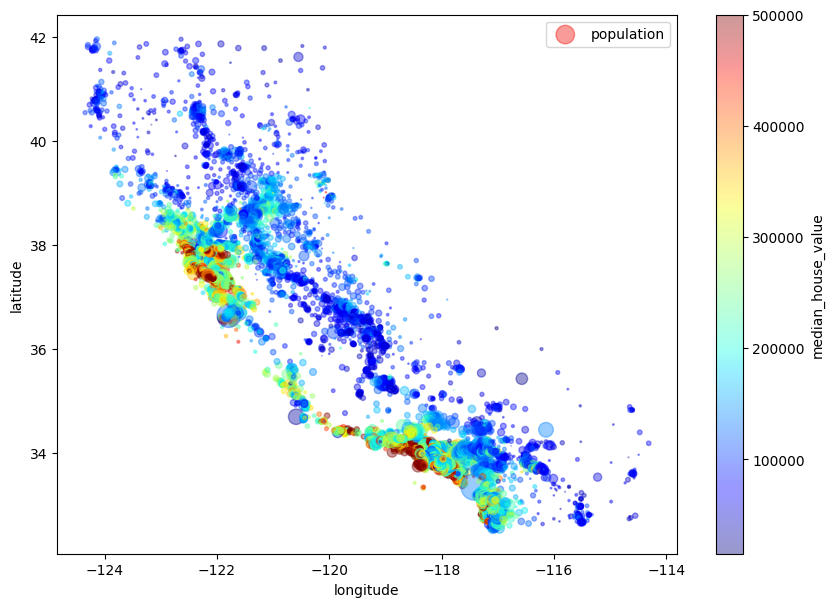

In [53]:
import matplotlib.pyplot as plt

df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=df['population']/100, label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

La question est cependant la suivante : *Quelle semble être la variable la plue corrélée au prix des maison (via la fonction corr ) ?*

<Axes: >

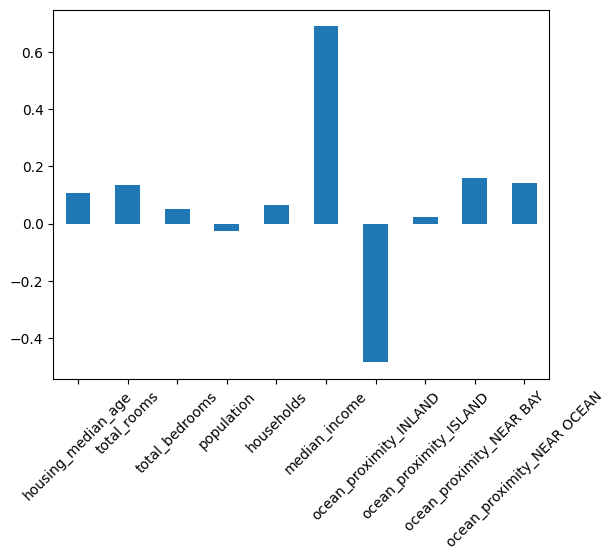

In [54]:
try:
    df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)
except KeyError:
    pass

corr = df.corr()['median_house_value']
del corr['median_house_value'], corr['longitude'], corr['latitude']
corr.plot(kind='bar', rot=45)

La variable la plus corrélée au prix des maisons est la variable median_income. On note aussi que le prix moyen est moins élevé à l'intérieur des terres.

On prépare les données pour l'entrainement.

1. Séparer les variables explicatives de la variable à expliquer.
2. Se débarasser des lignes qui ont des valeurs manquantes.
3. Remplacer les valeurs non numériques par des valeurs numériques. Nous l'avons fait en utilisant la fonction `get_dummies` de pandas précédemment.
4. Recalibrer les variables. Soit...
   * ...avec *min-max scaling* : TODO
   * ...avec *normalisation* : TODO

J'incorpore l'étape de séparation des données dans cette partie, car elle est plus pratique à faire après avoir fait le nettoyage des données.

In [55]:
# 2
df.dropna(axis=0, inplace=True)

# séparation train/test
from sklearn.model_selection import train_test_split

SEED = 0xDEADBEEF # avoid having different results each time
trainset, testset = train_test_split(df, test_size=0.2, random_state=SEED)

del df # A partir de maintenant, on utilise train et test


In [56]:

# 1
trainX = trainset.drop('median_house_value', axis=1, inplace=False)
trainY = trainset['median_house_value'].copy(deep=True)

print(trainX)

# 4
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
trainX = scaler.fit_transform(trainX)

print(trainX)


       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
22       -122.27     37.84                52.0       2436.0           541.0   
6560     -118.13     34.19                48.0       2539.0           425.0   
18581    -121.77     36.92                 9.0       4934.0          1112.0   
2818     -119.03     35.41                37.0       1761.0           443.0   
9721     -121.68     36.90                13.0        833.0           130.0   
...          ...       ...                 ...          ...             ...   
10166    -117.93     33.90                30.0       2629.0           331.0   
10444    -117.61     33.43                24.0       2303.0           399.0   
7044     -118.04     33.95                35.0       1945.0           357.0   
19617    -121.21     37.50                34.0        294.0            49.0   
12110    -117.35     34.01                23.0       3707.0           769.0   

       population  households  median_income  ocean

## Regréssion linéaire

In [58]:

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(trainX, trainY)

testX = testset.drop('median_house_value', axis=1, inplace=False)
testX = scaler.fit_transform(testX)
testYpred = lr.predict(testX)

from sklearn.metrics import mean_squared_error

print(mean_squared_error(testset['median_house_value'], testYpred))

print(testYpred[0])
print(testset["median_house_value"][0])

9434907279.639704
206757.21714018495
452600.0


In [60]:
print(lr.score(testX, testset['median_house_value'])) # Score sur les prédictions
print(lr.score(trainX, trainY)) # Score sur les données d'entrainement

0.2944030132497304
0.3314498757958584
